In [6]:
from quantum_electron import FullModel, PotentialVisualization, package_versions
from quantum_electron.initial_condition import InitialCondition
import numpy as np
from matplotlib import pyplot as plt

package_versions()

quantum_electron 0.2.0
numpy 1.24.2
scipy 1.11.4
matplotlib 3.7.1


The purpose of this example notebook is to illustrate the different initial conditions that are available in the `InitialCondition` class. This class offers a simple way to create initial conditions that can be fed into the `FullModel` class for solving for the electron positions.

`InitialCondition` currently supports three different initial conditions:
1. A circular pattern
2. A rectangular pattern
3. A random pattern confined to an area that's defined by a chemical potential.

Below, we show how to generate these initial conditions and how the choice of initial conditions can affect the convergence.

# Construct a potential

Below we generate a simple parabolic confinement in two dimensions.

In [7]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-2.5, 2.5, 401)
y = np.linspace(-2.5, 2.5, 401)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_confinement = 0.01*(- X ** 2 - Y ** 2) / micron ** 2 

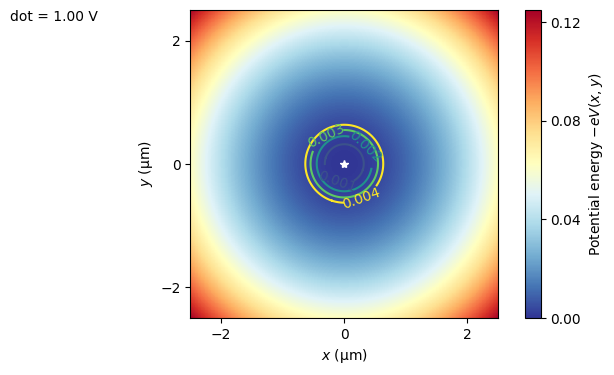

In [8]:
potential_dict = {"dot" : parabolic_confinement, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"dot" : 1.0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(5, 5))

In [23]:
options = {"f0" : 4e9, # Resonance frequency for the resonator (only used for solving motional frequencies)
           "Z0" : 50.0, # Resonator impedance (only used for solving motional frequencies)
           "include_screening" : False, # Include screening of electron-electron interactions due to thin film.
           "screening_length" : 2e-6, # Typically helium thickness.
           "potential_smoothing" : 1e-4, # Numerical smoothing of the splines (gets rid of some noise, can introduce artifacts)
           "remove_unbound_electrons" : False, # Removes electrons if they shot outside the solution box.
           "remove_bounds" : None, # Sets which electrons should be removed if above is True.
           "trap_annealing_steps" : [10] * 10, # List of annealing temperatures, length determines the number of steps
           "max_x_displacement" : 0.1e-6, # Maximum x-displacement of solved electron positions during annealing.
           "max_y_displacement" : 0.1e-6} # Maximum y-displacement of solved electron positions during annealing.

# Comparing initial conditions

To generate different initial conditions, we only have to instantiate the class once. The outputs of `make_circular` and other options are numpy arrays that can be fed into `get_electron_positions` below. 

To compare we feed each of the three functions below the same number of electrons. The argument `min_spacing` dictates the minimum distance between two electrons.

Note that the results below may be somewhat dependent on the potential. For example, if there is a finite barrier height such that electrons can possibly escape the trap area, certain initial conditions may be preferrable. Some trial and error should be expected for custom potentials.

In [30]:
n_electrons = 50
min_spacing = 0.1 # micron
n_rows = 5

assert n_electrons % n_rows == 0, "n_electrons must be divisible by n_rows"

ic = InitialCondition(potential_dict, voltages)
circular = ic.make_circular(n_electrons=n_electrons, min_spacing=min_spacing)
rectangular = ic.make_rectangular(n_electrons=n_electrons, dxdy=(2, 2), n_rows=n_rows)
chem_potential = ic.make_by_chemical_potential(max_electrons=n_electrons, chemical_potential=0.01, min_spacing=min_spacing)

In the cell below, note that the argument `n_electrons` is not important if `electron_initial_positions` is supplied. We could have set it to an arbitrary number.

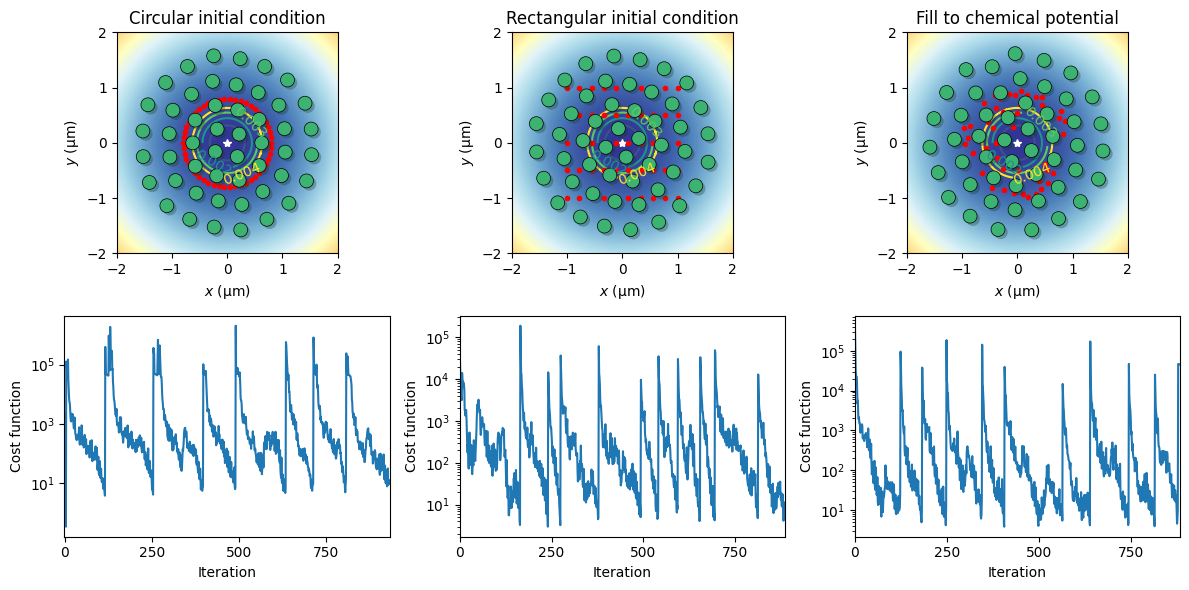

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(4*3, 6))
ax = ax.flatten()

f = FullModel(potential_dict, voltages, **options)

for k, init_cond in enumerate([circular, rectangular, chem_potential]):
    res = f.get_electron_positions(n_electrons=len(init_cond) // 2, electron_initial_positions=init_cond, verbose=False)
    # print(f.count_electrons_in_dot(res['x'], trap_bounds_x=(-2e-6, 2e-6), trap_bounds_y=(-2e-6, 2e-6)))
    f.plot_potential_energy(dxdy=(4, 4), ax=ax[k], plot_contours=True, print_voltages=False)
    ax[k].plot(init_cond[::2]*1e6, init_cond[1::2]*1e6, '.r')
    f.plot_electron_positions(res, ax=ax[k])

    f.plot_convergence(ax=ax[k+3])

ax[0].set_title("Circular initial condition")
ax[1].set_title("Rectangular initial condition")
ax[2].set_title("Fill to chemical potential")
fig.tight_layout()

The final electron configuration shouldn't depend on the intial state, so all three plots in the top rows should be (rotated) copies. Additionally, for each method we see several cycles of repeated convergence, indicating the annealing tried to find a lower energy state. Because the `make_by_chemical_potential` method relies on a random number generator, we can expect to see some randomness in the convergence as we run the cell repeatedly.

It is also instructive to look at the convergence methods in real time. For example, for the final method we animate this convergence process below:

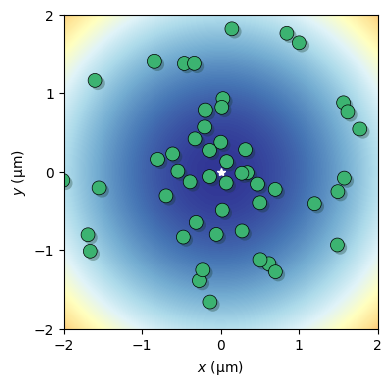

In [12]:
amim = f.animate_convergence(dxdy=(4, 4), frame_interval_ms=25)

In [13]:
f.show_animation(amim)